# iPhone X vs Galaxy S9

Tae Jang, Soi Kang

Video Link:

https://youtu.be/ejwLm8Dgfgg


<table>
<tr><td><img src="A_logo.JPG" width="100px" style="float"></td>
    <td>VS</td>
    <td> <img src="S_logo.JPG" width="200px" style="left"></td>
</tr></table>

> Apple iPhone and Samsung Galaxy are known to be top two competitors in the smartphone market. Our team wanted to know what the consumers think of these two products. We determined that iPhone X and Galaxy S9 will be a fair comparison because the release dates were only 4 months apart.

>iPhone X Release Date: **November 3, 2017**

>Galaxy S9 Release Date: **March 16, 2018**

>These two products have different features and functions. We will explore these reviews to extract insigts that can help with business decisions.

<u>Disclaimer</u>

\* Our team carefully regarded ethical consideration and scraped only from the websites that allows data scraping. 

<br>

In [3]:
# load necessary libraries
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from collections import Counter
import gensim
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_lg')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import ipywidgets as widgets
import seaborn as sns

C:\Users\tkjan\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\tkjan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Review of Data Acquisition and Processing

We scraped the 6 websites below using BeautifulSoup and Selenium. More websites were considered, but not every website had both phone reviews or didn't have 5-star rating system or review system. For the sake of this analysis, scraped only basic model of both phones (e.g. S9 rather than S9+). Scraping codes are included in the folder 'scrapers' and the dataframes extracted from these websites are also saved separately in 'scraped-data' folder.

Scraped websites : 
1. Best-Buy(Electronic and Product Sale) 
2. Verizon(Telecommunication) 
3. AT&T(Telecommunication) 
4. influenster.com(E-Commerce for Daily Products) 
5. ProductReview.au(Electronic Sale/Purchase company in Australia) 
6. very.co.uk(Electronic Sale/Purchase company in the United Kingdom) 

#### We have saved the scraped data as 'final_data.csv' and EDA starts from this

In [2]:
# read the data in
df = pd.read_csv('data/final_data.csv')

# count by source and type of phone
pd.pivot_table(df, index='source', columns='phone', aggfunc='size')

phone,galaxy,iphone
source,,
BestBuy,1606,39
Productreview.com.au,111,660
Very.co.uk,7620,500
att.com,268,1117
influenster,95,990
vw,74,170


In [3]:
# count by rating and type of phone
pd.pivot_table(df, index='phone', columns='rating', aggfunc='size')

rating,1,2,3,4,5
phone,,,,,
galaxy,277,252,535,1673,7037
iphone,127,97,179,501,2572


We labeled rating 1, 2 as negative sentiment (N) and 4, 5 as positive sentiment (P). We went through all the rating 3 reviews and labeled it manually. We indicated some reviews as '?' which do not express any sentiment such as the reviews written in foreign language and very neutral sentiment. There were 32 reviews of those out of 13250 total observations and we eventually dropped all the '?'s and ended up with 13218 rows.

#### After labeling, it is saved as 'final_data_labeld.csv'

In [4]:
df = pd.read_csv("data/final_data_labeled.csv", index_col = False)

pd.pivot_table(df, index='phone', columns='sentiment',aggfunc='size',fill_value='0')

sentiment,?,N,P
phone,,,
galaxy,29,895,8850
iphone,3,353,3120


In [5]:
df = df[df['sentiment'] != '?'].reset_index(drop=True)
print("total rows : " +str(len(df)))

pd.pivot_table(df, index='phone', aggfunc='size')

total rows : 13218


phone
galaxy    9745
iphone    3473
dtype: int64

## Adding features

As above table depcts, iPhone X and Samsung S9 reviews were scraped 6 different product review websites. Count of Galaxy reivews are three times as much as iPhone reivews (very.co.uk had a significantly more Galaxy S9 reviews.) After cleaning, total of 13218 reviews are used in this analysis.

1. **phone** : iphone and galaxy

+ **rating** : 1 - 5 stars

+ **sentiment** : 5 and 4 stars are 'P' meaning positive reviews. 1 and 2 stars are 'N'. 3 stars were manually labels after reading the reviews.

+ **review** : actual reviews in string

+ **source** : productreview.com.au, very.co.uk, bestbuy.com, att.com, verizon.com, influenster.com

+ **cleaned** : special characters and non ASCII characters removed

+ **filtered** : stopwords removed from "cleaned"

+ **len_org** : number of organization mentioned in each review (e.g. 'Samsung' in the review will be counted as one.)

       spaCy correctly identifys comnany names. 'Samsung', 'Apple' 'Sony' will be tagged as 'ORG'.

+ **len_adj** : number of adjectives appeared in each review
       
       spaCy tagger will indentify all of adjectives as 'ADJ'

+ **len_ch** : number of characters in each review (e.g. 'I love Apple' would be 10 characters)

+ **positivity** : Used SentimentIntensityAnalyzer in nltk.vader library. The positivity score is calculated based on a dictionay of words and associated positive scores. Cool thing about this function is that special characters are taken into consideration when the scores are calculated.
        
        e.g. I love this phone. vs I love this phone!
        
        SentimentIntensityAnalyzer will assign higher positivity to second sentence.
        
+ **negativity** : Used SentimentIntensityAnalyzer in nltk.vader. The negativity score is calculated based on a dictionay of words and associated negative scores. Cool thing about this function is that special characters are taken into consideration when the scores are calculated.

        e.g. I hate this phone. vs I hate this phone!
        
        SentimentIntensityAnalyzer will assign higher negativity to second sentence.
        
    <u>\* one review can have both non-zero positivity and negativity scores</u>

+ **compound** : both posivitiy and negativity score was taken into consideration and normalized to calculate compound socre

+ **num_pos** : number of positive words

       each word in reviews was quantified (semtiment > 0) via Textblob

+ **num_neg** : number of negative words

       each word in reviews was quantified (semtiment < 0) via Textblob

+ **polarity** : Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement.

+ **treated_negativity** : negativity score AFTER treating double negations in each review

+ **treated_positivity** : positivity score AFTER treating double negations in each review

+ **treated_compound** : compound score AFTER treating double negations in each review

In [6]:
# 1) Adding "cleaned" review as a feature
reviews = df['review']
stopwords = nltk.corpus.stopwords.words('english')

# df with one column
data = reviews.to_frame()
# remove non ASCII characters & special characters
df['cleaned'] = data['review'].apply(lambda x : ' '.join(e for e in x.split(" ") if e.isalnum()))

# 2) Adding "filtered" review as a feature : this is to remove stopwords
word_tokens = []

for review in df['cleaned'] :
    tokens = word_tokenize(str(review))
    word_tokens.append(tokens)

filtered_sentence = []
for tokens in word_tokens :
    filtered_review = [w for w in tokens if not w.lower() in stopwords] 
    filtered_sentence.append(filtered_review)

filtered = pd.DataFrame({'filtered' : filtered_sentence})
df['filtered'] = filtered
df['filtered'] = df['filtered'].apply(' '.join)

In [7]:
# 3) count of adjectives in each review 
# 4) count of brand name(s) mentioned in each review
# 5) count of characters in each review
leng =[]
len_org = []
len_char = []
for i in range(len(df)):
    
    k = len(df['review'][i]) #count of chars
    len_char.append(k)
    
    text = nlp(df['review'][i])
    len_org.append(len(text.ents)) #count of brand names
    
    for token in text:
        if token.pos_ == "ADJ":
            tk=len(token)
    leng.append(tk) #count of adj
    
df['len_org'] = len_org # freq of organiztion mentioned
df['len_adj'] = leng # freq of adjectives
df['len_ch'] = len_char # count of character

In [8]:
# 6) adding negativity, positivity, and compound scores

negativity=[]
positivity=[]
compound=[]

sid = SentimentIntensityAnalyzer()
for i in range(len(df)):
    score=sid.polarity_scores(df['review'][i])
    score.keys()
    neg=list(score.values())[0]
    pos=list(score.values())[2]
    comp=list(score.values())[3]
    
    negativity.append(neg)
    positivity.append(pos)
    compound.append(comp)

df['negativity'] = negativity
df['positivity'] = positivity
df['compound'] = compound

In [9]:
# 7) adding number of positive words and negative words

num_pos = []
num_neg = []

# 'filtered' is already without stopwords and special characters. we will use filtered column
# filter it once more to make sure it's clean
filtered = df['filtered'].map(lambda x: re.sub(r'\W+', ' ', str(x)))

for review in filtered :
    pos_counter = 0
    neg_counter = 0
    for word in word_tokenize(review):
        if(TextBlob(word).sentiment[0] > 0) :
            pos_counter = pos_counter+1
            #print(TextBlob(word).sentiment[0])
            
        elif (TextBlob(word).sentiment[0] < 0) :
            neg_counter = neg_counter+1
            #print(TextBlob(word).sentiment[0])
        
        else :
            pass
        
    num_pos.append(pos_counter)
    num_neg.append(neg_counter)

df['num_pos'] = num_pos
df['num_neg'] = num_neg

In [10]:
# 8) adding polarity scores based on the original review. polarity score is from textblob library

df['polarity'] = df['review'].apply(lambda x : TextBlob(x).sentiment[0])

####  The below is what our master_data looks like and we have saved the file as 'master_data.csv' so that we do not have to run the above code again.

In [11]:
# we have saved the file after adding the necessary features as 'master_data.csv'

df.to_csv('data/master_data.csv', index=False)


In [12]:
df.head()

,phone,rating,sentiment,review,source,cleaned,filtered,len_org,len_adj,len_ch,negativity,positivity,compound,num_pos,num_neg,polarity
0,galaxy,5,P,The Samsung Galaxy s9 is arguably the most bea...,Productreview.com.au,The Samsung Galaxy s9 is arguably the most bea...,Samsung Galaxy s9 arguably beautiful phone eve...,5,7,395,0.025,0.227,0.9476,4,0,0.558333
1,galaxy,5,P,"great phone smart features easy to use ,, , p...",Productreview.com.au,great phone smart features easy to use plenty ...,great phone smart features easy use plenty goo...,0,4,224,0.000,0.424,0.9590,6,0,0.624603
2,galaxy,4,P,I really liked the phone. It has good camera w...,Productreview.com.au,I really liked the It has good camera which is...,really liked good camera best feature good cha...,1,4,155,0.000,0.419,0.9421,6,0,0.640000
3,galaxy,3,P,First of all the camera quality does not disap...,Productreview.com.au,First of all the camera quality does not as ar...,First camera quality samsung cameras excellent...,4,5,382,0.033,0.109,0.7317,4,1,0.185625
4,galaxy,4,P,"As a flagship phone goes, everything is pretty...",Productreview.com.au,As a flagship phone everything is pretty Speed...,flagship phone everything pretty Speed touch i...,3,2,605,0.056,0.111,0.7269,7,1,0.158333


# Analysis

### Exploratory Data Analysis

We are mostly interested in correlation to rating variable. Rating has to have some pattern or relationship with these variables.

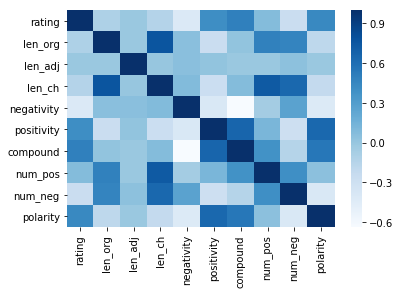

In [4]:
# the correlation between the numeric variables which we created
df = pd.read_csv('data/master_data.csv')
corr=df.corr()
sns.heatmap(corr, cmap= "Blues",
        xticklabels=corr.columns,
        yticklabels=corr.columns);

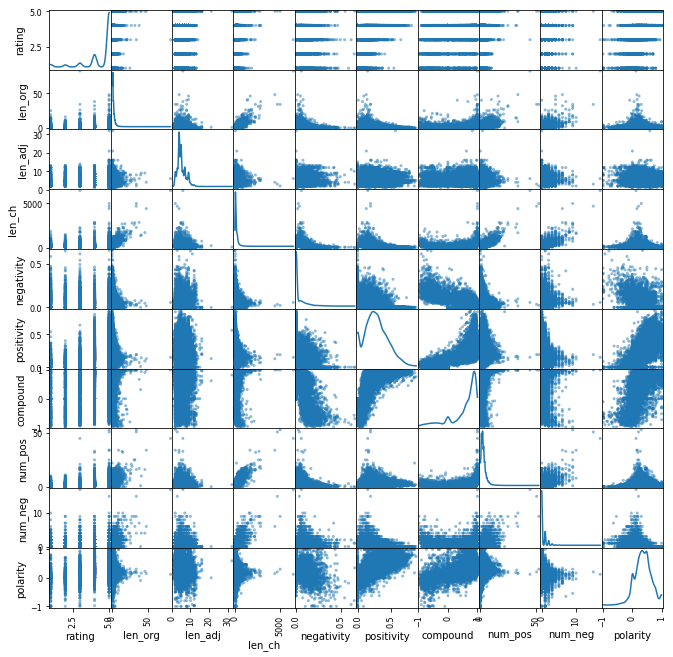

In [5]:
pd.plotting.scatter_matrix(df, figsize=(11, 11), diagonal='kde')
plt.show()

### Exploratory Data Analysis continued

After examining the scatter plot matrix, we decided to closely look at the feature variables and the association with the rating by creating the plots and compare them one another.


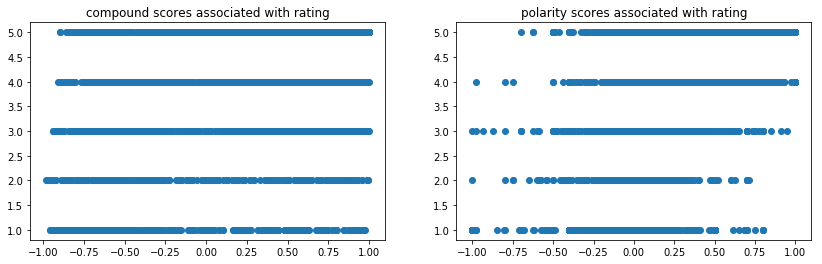

In [6]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.set_title("compound scores associated with rating")
ax.plot(df['compound'], df['rating'], 'o')
ax2.plot(df['polarity'], df['rating'], 'o')
ax2.set_title("polarity scores associated with rating")
plt.show()

> Compoud scores don't makes sense. You should be able to see steps rising toward northweast corner. It is minimally resembling the true polarity. In the perfect world, again, you should be able to see steps rising toward northweast corner.

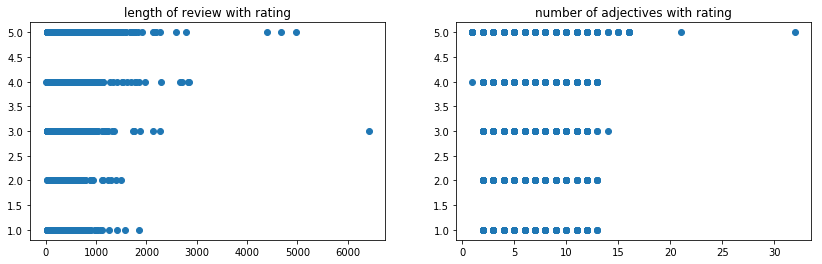

In [7]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.set_title("length of review with rating")
ax.plot(df['len_ch'], df['rating'], 'o')
ax2.plot(df['len_adj'], df['rating'], 'o')
ax2.set_title("number of adjectives with rating")
plt.show()

> The trend is that the higher the ratings are the longer the reviews are. With count of adjectives, our team expected to see $\huge\subset$ shape. 5 and 1 star will have more adjectives. It seems to agree with 5 stars, but not 1 stars.

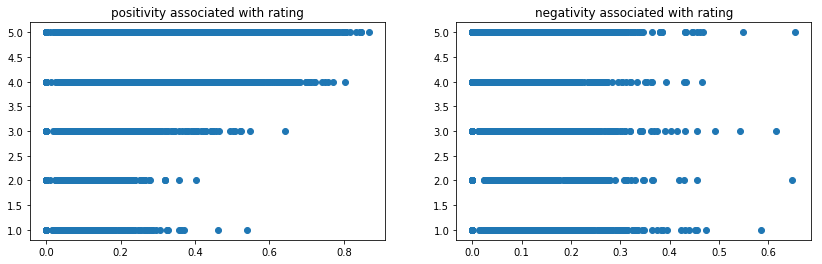

In [8]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.set_title("positivity associated with rating")
ax.plot(df['positivity'], df['rating'], 'o')
ax2.plot(df['negativity'], df['rating'], 'o')
ax2.set_title("negativity associated with rating")
plt.show()

> Above plots are interesting because postivity is resembling the true shape of rating distribution (the higher the ratings, the higher the positivity scores are). Similarly, we would expect the lower the ratings, the lower the negativity scores are. 

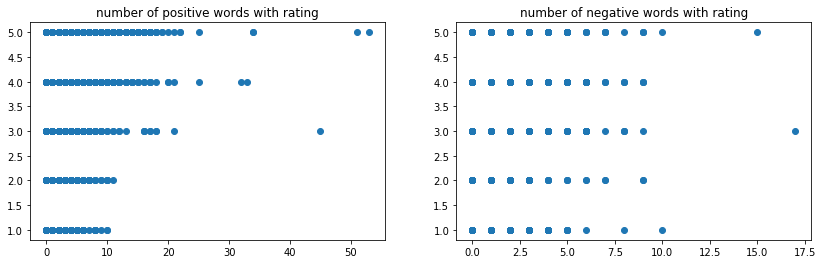

In [9]:
f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.set_title("number of positive words with rating")
ax.plot(df['num_pos'], df['rating'], 'o')
ax2.plot(df['num_neg'], df['rating'], 'o')
ax2.set_title("number of negative words with rating")
plt.show()

> We decided to count positive and negative words to confirm. The results were consistent as above posotivity and negativity plots. Number of positive words mostly agree with ratings, but again, number of negative words are messy. We highly suspect that this is because of "double negations" as the example in the next code chunk. Let's see if we can fix this by treating double negations. We will cover this topic extensively in "Treating Double Negated Phrases" below. 

## Treating double negated phrases

As the example below (legit phone not bad aspects : rating 5), we want to take care of the double negations which might be messing with our data. We decided to create a list of double negated phrases from our dataset. Using bigrams, we will sift double negatives and create a list in order to nullify the double negatives.

1. go through the list from ratings 4 and 5 and retrieve double nagated words
2. we defined double negative phrases as whatever contains "no" as the first word and the following word should be a negative adjective. For example, "not bad" should be in our list. The reason why we defined the first word to be explicitly "no" is because both nltk and textblob library consider "no" doesn't contain any sentiment. Polarity score of "no" from textblob is 0.0 and the negativity score from nltk was also 0.0

3. Once the phrase is found, add it to the list.

In [10]:
### double negation example ###

# This is a 5-star review, but negativity score is 0.655 when positive score is 0.
n=13201
sid = SentimentIntensityAnalyzer()
print(sid.polarity_scores(df['review'][n]))
print('rating: ', df['rating'][n])
print(df['num_neg'][n])
df['review'][n]


{'neg': 0.655, 'neu': 0.345, 'pos': 0.0, 'compound': -0.6908}
rating:  5
1


'Legit phone no bad aspects'

In [11]:
# use cleaned review
filtered = df['cleaned']

#Lemmatization before sifting double negatives
lemmatizer=WordNetLemmatizer()
tok = filtered.apply(lambda x : word_tokenize(str(x)))
lem = tok.apply(lambda x : [lemmatizer.lemmatize(_) for _ in x])
lem_rat = pd.concat([lem, df['rating']], axis=1)

#list for bigrams of all the reviews
# also added rating next to each bigram
bigrams =[]
for i in range(len(lem_rat['cleaned'])) :
    for ngram in (ngrams(lem_rat['cleaned'][i], 2)) :
        bigrams.append(' '.join(str(i) for i in ngram))
        bigrams.append(lem_rat['rating'][i])
        
#list for possible double negatives
double_negatives = []

for i in range(0, len(bigrams), 2):
    tokens = word_tokenize(bigrams[i])
    #if both words are negative
    if(("no" in tokens[0]) & (TextBlob(tokens[1]).sentiment[0]<0)):
        double_negatives.append(bigrams[i])
        double_negatives.append(bigrams[i+1])
    
    
# let's separate the list and make it as a dataframe
d_neg = []
d_rat = []

i = 0
while(i < len(double_negatives)):
    d_neg.append(double_negatives[i])
    i=i+1
    d_rat.append(double_negatives[i])
    i=i+1

# list to a dataframe
d_neg_rat = pd.DataFrame({'negative bigrams' : d_neg, 'associated rating' : d_rat})

# export
d_neg_rat.to_csv('data/doub_neg.csv', index=False)

#### From the code above, we have acquired a list of double negatives out of our dataset. The list looks like below and we also have saved it as "doub_neg.csv" file so this code chunk doesn't have to be run.

In [12]:
d_neg_rat.head(10)

,associated rating,negative bigrams
0,3,now down
1,5,no mean
2,5,not bad
3,2,nothing Less
4,5,not broken
5,5,technology difficult
6,5,no complaint
7,1,not serious
8,2,annoying worst
9,3,not tough


In [13]:
d_neg_rat = pd.read_csv('data/doub_neg.csv')
pd.pivot_table(d_neg_rat, columns='associated rating', aggfunc='size')

associated rating
1      3
2      6
3     15
4     22
5    108
dtype: int64

> We can see there are way more 4s and 5s in the rating that are associated with double negated phrases.

## Plotting after removing double negated phrases

### Part1. Getting the list ready
<br>

**Trimming the list**

Out of the list we have created, we observed that there are phrases that are not double negated such as "technology difficult". We manually went through the list and deleted non-double negated phrases. We have saved the file as "doub_deg_edited.csv".

**Updating the list**

We wanted to look into the negativity score even more closely and see if there is any more phrases we want to include. Using our double negated phrase list, we created a subset which is rating 5s and the negativity score above 0.2. There were 146 occurrences in the subset. After we examine the subset, we figured out that there are actually more double negations in the reviews which we did not include in our double negation lists such as 

- no regret
- no fault
- no problem
- coudn't be happier
- no complain

We added these phrases in to our double negation list and updated it.

In [14]:
d_list = pd.read_csv('data/doub_neg_edited.csv') #this is the trimmed list
d_list = d_list.dropna()
d_list = list(d_list['negative bigrams'])

unique = list(set(d_list))
print("length of our trimmed list : " +str(len(unique)))

length of our trimmed list : 32


In [15]:
# examine the review with negativity score and rating to update our doube negative list.

test = df[['review','negativity','rating']]
liars = test[(test['rating']==5) & (test['negativity']>0.30)].sort_values(by='negativity', ascending=False)
liars['review'].values

array(['Legit phone no bad aspects',
       'This does everything I need. Absolutely no disappointments!',
       'Bought phone a few weeks ago absolutely no regrets',
       'Brill phone no faults couldnt ask for a better phone :)',
       'Apps are difficult to find. Start-up was difficult',
       'Flawless had it for 3 months so far. No problems or negative comments',
       'Great phone no fault yet............................',
       "Had phone one week couldn't be happier best phone ever",
       'I love it I got no complain',
       'I bought this phone a week ago still learning but no regrets',
       "I have it less than 14 days and don't like it, I LOVE my phone!!!",
       'Bit disappointed no built-in radio like my old phone',
       'Got this as an upgrade, had no problems with it transferred everything over from my old s7 with no problems.',
       "I've had this phone for one month now. No complaints",
       "Got this phone a month ago and I've got no complaints",
   

In [16]:
d_list = pd.read_csv('data/doub_neg_edited.csv')
d_list = d_list.dropna()
d_list = list(d_list['negative bigrams'])

#add more double negative phrases and the associated ratings into our double negative lists
more = ["no regret", "no fault", "no problem", 'couldn\'t be happier', "no complain"]

for word in more :
    d_list.append(word)

unique = list(set(d_list))
print("length of our updated list : " +str(len(unique)))

length of our updated list : 37


> After updating the list, we ended up having 37 double negation phrases.

### Part 2. Removing double negated phrases from the review

Now that we have a list of double negations extracted from our dataset, we decided to see if that would change the negativity plots. We will nullify the double negated phrases using our double negative list and create the plots again to see any difference.

In [17]:
# let's try to remove only those phrases above in the reviews

mylist = list(map(str.lower, unique))

#create a copy of the dataframe
data = df[['review','rating']]

#list of strings to be removed from
review = data['review']
rating = data['rating']
zipped = list(zip(review, rating))

test = zipped
mylist = list(unique)

tup1 = []
tup2 = []
for i in range(len(test)) :
    current = test[i][0]
    current_rating = test[i][1]
    for word in mylist :
        if word in current.lower():
            #print(word)
            current = current.replace(word, '') #remove it?
    
    tup1.append(current)
    tup2.append(current_rating)
    
test_d = pd.DataFrame({'treated' : tup1, 'rating' :tup2})
test_d.head(10)

,rating,treated
0,5,The Samsung Galaxy s9 is arguably the most bea...
1,5,"great phone smart features easy to use ,, , p..."
2,4,I really liked the phone. It has good camera w...
3,3,First of all the camera quality does not disap...
4,4,"As a flagship phone goes, everything is pretty..."
5,2,"Had Samsung S9 for just over 1 month, battery ..."
6,5,The camera quality is very good with this phon...
7,5,Fantastic phone. The camera is great and the s...
8,4,"Camera quality is decent, occasionally plays u..."
9,5,My New Samsung S9 is my go to girl . I simply ...


In [18]:
# now that we have removed the double negative phrases from the review, let's get the negativity score and compare the plots.

negativity=[]
positivity=[]
compound=[]
sid = SentimentIntensityAnalyzer()

for i in range(len(data)):
    score=sid.polarity_scores(test_d['treated'][i])
    score.keys()
    neg=list(score.values())[0]
    pos=list(score.values())[2]
    comp=list(score.values())[3]
    
    negativity.append(neg)
    positivity.append(pos)
    compound.append(comp)

print("negativity length : " +str(len(negativity)))
print("positivity length : " +str(len(positivity)))
print("compound length : " +str(len(compound)))

df['treated_negativity'] = negativity
df['treated_positivity'] = positivity
df['treated_compound'] = compound

negativity length : 13218
positivity length : 13218
compound length : 13218


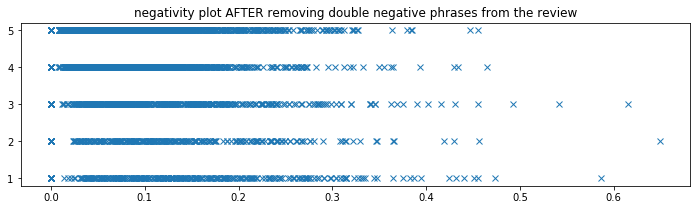

13218


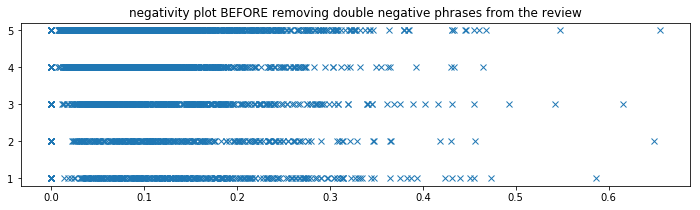

13218


In [19]:
plt.figure(figsize=(12,3))
plt.title("negativity plot AFTER removing double negative phrases from the review")
plt.plot(df['treated_negativity'], df['rating'], 'x')
plt.show()
print(len(test_d)) #13218

plt.figure(figsize=(12,3))
plt.title("negativity plot BEFORE removing double negative phrases from the review")
plt.plot(df['negativity'], df['rating'], 'x')
plt.show()
print(len(df)) #13218

> After removing the double negated phrases, we saw some changes in our plot. It removed some of the outliers that had higher negativity scores with higher rating. We now know that treating double negative was one thing to improve our model accuracy based on our dataset.


# Identifying the features and sentiments

We are trying to extract the features of each brand that make them popular and unique to identify which features are driving positive reviews and which features are the ones that the consumers did not like.


### Part1.  Most common bi-grams within negative reviews

We started with examining the most common phrases that consist of two words (bi-gram) within negative reviews. N-gram will output every combination of n sequencial words in a review. Here, we are adding all of tokenized words into a list and getting the frequencies of n-grams. Since we are creating n-grams with "N" sentiment for each product, this will give us **clearer ideas of what customers are NOT happy about**.

In [20]:
from collections import Counter
import re
from nltk import ngrams

#Preparing separate data-sets for the samsung and apple phones:
samsung = df[df['phone']=='galaxy']
iphone = df[df['phone']=='iphone']

samsung = samsung.reset_index()
iphone = iphone.reset_index()

# negative sentiment only
df_s_n = samsung[samsung['sentiment'] == 'N']['filtered'].apply(lambda x : word_tokenize(x))
df_a_n = iphone[iphone['sentiment'] == 'N']['filtered'].apply(lambda x : word_tokenize(x))

df_s_n = list(df_s_n)
df_a_n = list(df_a_n)

In [21]:
# galaxy negative review 2-gram

master_2grams_s =[]

for i in range(len(df_s_n)) :
    for ngram in (ngrams(df_s_n[i], 2)) :
        master_2grams_s.append(' '.join(str(i) for i in ngram))

print("Negative review most common bigrams for galaxy top 20")
Counter(master_2grams_s).most_common()[0:19]


Negative review most common bigrams for galaxy top 20


[('battery life', 58),
 ('phone week', 33),
 ('bought phone', 32),
 ('week ago', 31),
 ('weeks ago', 25),
 ('2 weeks', 23),
 ('s7 edge', 22),
 ('Samsung Galaxy', 21),
 ('got phone', 20),
 ('old phone', 19),
 ('month ago', 19),
 ('3 weeks', 16),
 ('go back', 15),
 ('two weeks', 14),
 ('2 years', 13),
 ('Battery life', 13),
 ('phone last', 13),
 ('new phone', 12),
 ('Galaxy S9', 12)]

In [22]:
# iphone negative review 2-gram

master_2grams_a =[]

for i in range(len(df_a_n)) :
    for ngram in (ngrams(df_a_n[i], 2)) :
        master_2grams_a.append(' '.join(str(i) for i in ngram))

print("Negative review most common bigrams for iphone top 20")
Counter(master_2grams_a).most_common()[0:19]



Negative review most common bigrams for iphone top 20


[('iPhone X', 56),
 ('home button', 26),
 ('Face ID', 17),
 ('face recognition', 15),
 ('iPhone 6', 12),
 ('iPhone 7', 12),
 ('facial recognition', 12),
 ('battery life', 11),
 ('iPhone 8', 9),
 ('iphone x', 8),
 ('screen protector', 8),
 ('full screen', 8),
 ('much better', 7),
 ('screen size', 7),
 ('phone X', 6),
 ('think worth', 6),
 ('use phone', 6),
 ('phone 2', 6),
 ('IPhone X', 6)]

Here are some of things we can infer from our n-gram analysis.

iPhone X

1. Users are not happy about home button iPhone X.

+ Users thinks iPhone X is expensve.

+ Users are not happy about face recognition of iPhone X.


Galaxy S9

1. users are not happy with battery life Galaxy S9 .

+ Many user are writing the review 2 or 3 weeks after they bought the phone.

+ Buying cycle can be carefully infered. A consideralble count of review is stating that users upgraded from S7.


## Part2. Identifying sentiment of 3-grams containing smartphone features/functionalities

Our wanted to go step above from the 2-gram analysis. Here we are quantifying the sentiments of features/functionalities. The following steps can be a little confusing, but bare with us for a minute.

#### Methodology

- divide the dataset to iphone and galaxy


- find most common single-grams


- hand-pick the features/functionalities of each smartphone


- generated 3-grams for each smartphone


- sift the 3-grams that contains the hand-picked features/functionalities for each smartphone


- put these 3-grams into dictionaries according to their features/functionalities


- combine features/functionalities that are simliar to each other
    
       e.g. camera & photo & picture were combined into "camera"


- analyze the sentiment of each dinctionary

In [23]:
#Preparing separate data-sets for the samsung and apple phones:
samsung = df[df['phone']=='galaxy'].reset_index(drop=True)
iphone = df[df['phone']=='iphone'].reset_index(drop=True)
s_list = samsung['filtered']
a_list = iphone['filtered']

s_list = list(s_list)
a_list = list(a_list)

In [24]:
# most common words in galaxy reviews
sam = []

for i in range(len(s_list)):
    for tok in word_tokenize(str(s_list[i]).lower()) :
        sam.append(tok)  

common_sam = Counter(sam).most_common()

# most common words in iphone reviews
app = []

for i in range(len(a_list)):
    for tok in word_tokenize(str(a_list[i]).lower()) :
        app.append(tok)  

common_app = Counter(app).most_common()

In [25]:
# examples of most common single-grams

print(common_sam[0:9])
print(common_app[0:9])

[('phone', 6211), ('great', 2232), ('love', 2138), ('samsung', 2097), ('s9', 1543), ('camera', 1542), ('good', 1304), ('bought', 1287), ('features', 1116)]
[('phone', 2527), ('iphone', 2501), ('love', 1413), ('x', 1152), ('screen', 956), ('apple', 884), ('great', 835), ('like', 822), ('camera', 796)]


> We extracted the feaures (functionalities of the phones) based on the counts of certain words in the reviews related to the brand. We went through the most commonly occurring words and identified the features of a smarphone only.

In [26]:
# already filtered and tokenized lists to process the tri-grams
filtered_samsung = df[df['phone']=='galaxy']['filtered'].apply(lambda x : word_tokenize(str(x).lower()))
filtered_iphone = df[df['phone']=='iphone']['filtered'].apply(lambda x : word_tokenize(str(x).lower()))

filtered_samsung = list(filtered_samsung)
filtered_iphone = list(filtered_iphone)

In [27]:
#We create a tri-gram from the filtered review set. 

# create a list of trigrams for samsung features
s_tri = []
for i in range(len(filtered_samsung)) :
    for ngram in (ngrams(filtered_samsung[i], 3)) :
        s_tri.append(' '.join(str(i) for i in ngram))

# create a list of trigrams for iphone features
a_tri = []
for i in range(len(filtered_iphone)) :
    for ngram in (ngrams(filtered_iphone[i], 3)) :
        a_tri.append(' '.join(str(i) for i in ngram))

C:\Users\tkjan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: generator 'ngrams' raised StopIteration
  
C:\Users\tkjan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: generator 'ngrams' raised StopIteration
  if sys.path[0] == '':


In [28]:
#Features are extracted based on the occurence and count of certain words in the reviews related to the brand.
s_features = ['camera', 'screen', 'battery', 'iphone',  'apps', 'button', 
              'pictures' , 'design', 'sound',  'size',  'price',  'display', 'battery', 'bixby',
              'fingerprint']

samsung_features = []

for item in s_tri :
    for feature in s_features :
        if feature in item.lower() :
            samsung_features.append(item)
            
# A dictionary is created for every common feature and the tri-gram associated with the same feature.
# key is the feature and the associated tri grams are the values.
sam_dict = {}
s_keys = s_features

for key in s_keys:
    for j in range(len(samsung_features)):
        if key in samsung_features[j] :
            if key in sam_dict :
                sam_dict[key].append(samsung_features[j])
            else :
                sam_dict[key] = [samsung_features[j]]
                

In [29]:
a_features = ['screen','camera', 'button' ,'face', 'size','recognition', 'price', 'battery' ,
                   'apps', 'design', 'photos', 'display','pictures', 'videos', 'charging',  'samsung']

apple_features = []

for item in a_tri :
    for feature in a_features :
        if feature in item.lower() :
            apple_features.append(item)
            
# A dictionary is created for every common feature and the tri-gram associated with the same:
app_dict = {}
a_keys = a_features

for key in a_keys:
    for j in range(len(apple_features)):
        if key in apple_features[j] :
            if key in app_dict :
                app_dict[key].append(apple_features[j])
            else :
                app_dict[key] = [apple_features[j]]
                

In [30]:
#histogram of the features of galaxy s9

s_hist = []
s_hist_feat = []
for i, j in common_sam :
    if i in s_features :
        s_hist.append(j)
        s_hist_feat.append(i)

a_hist = []
a_hist_feat = []
for i, j in common_app :
    if i in a_features :
        a_hist.append(j)
        a_hist_feat.append(i)

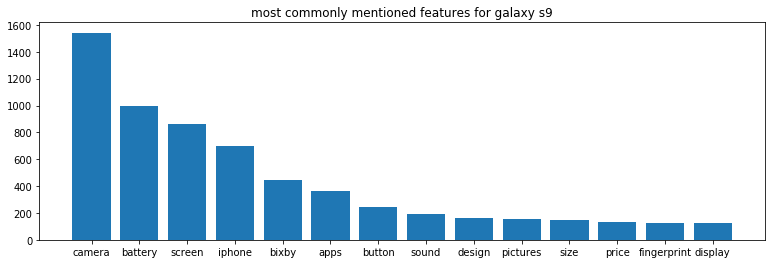

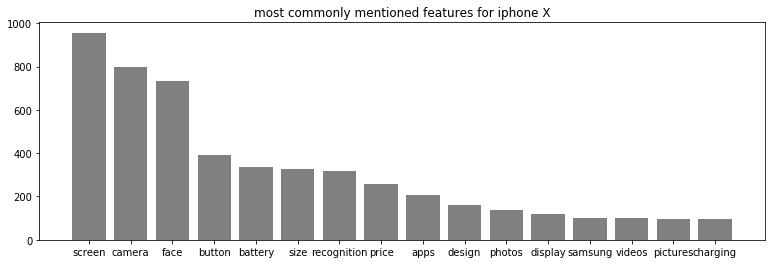

In [31]:
# create histogram plots
plt.figure(figsize=(13, 4))
plt.bar(s_hist_feat, s_hist)
plt.title("most commonly mentioned features for galaxy s9")
plt.show()

plt.figure(figsize=(13,4))
plt.bar(a_hist_feat, a_hist, color="gray")
plt.title("most commonly mentioned features for iphone X")
plt.show()

### Using NLTK-Library to Analyze the sentiments

nltk.vader library is used in this case to extract the positivity and the negativity score of each features and the combined features in general, this should give us a holistic idea of whether a feature is liked or disliked. This will help us identify the areas of improvement for each brand.

In [32]:
# Now that we have dictionaries that hold tri-grams associated with the features as values,
# we can create lists of individual feature to extract sentiments regarding them

s_battery = list(dict.fromkeys(sam_dict["battery"]))
s_cam  = list(dict.fromkeys(sam_dict["camera"])) + list(dict.fromkeys(sam_dict["pictures"]))
s_price = list(dict.fromkeys(sam_dict["price"]))
s_button = list(dict.fromkeys(sam_dict["button"]))
s_bixby = list(dict.fromkeys(sam_dict["bixby"]))
s_display = list(dict.fromkeys(sam_dict["display"]))
s_screen = list(dict.fromkeys(sam_dict["screen"]))
s_app = list(dict.fromkeys(sam_dict["apps"]))

a_screen  = list(dict.fromkeys(app_dict["screen"]))
a_cam  = list(dict.fromkeys(app_dict["camera"])) + list(dict.fromkeys(app_dict["pictures"])) + list(dict.fromkeys(app_dict["photos"]))
a_face = list(dict.fromkeys(app_dict["face"])) + list(dict.fromkeys(app_dict["recognition"]))
a_price = list(dict.fromkeys(app_dict["price"]))
a_button = list(dict.fromkeys(app_dict["button"]))
a_design = list(dict.fromkeys(app_dict["design"]))
a_display = list(dict.fromkeys(app_dict["display"]))
a_app = list(dict.fromkeys(app_dict["apps"]))                                                                                               
                                                                                                   

In [33]:
# extract the sentiment from the trigrams

sid = SentimentIntensityAnalyzer()

ss = [s_battery, s_cam, s_price, s_button, s_bixby, s_display,s_screen, s_app]
s_feat = ["battery", "camera", "price", "button" , "bixby", "display","screen", "apps"]
aa = [a_screen, a_cam, a_face, a_price, a_button, a_design, a_display, a_app]
a_feat = ["screen", "camera", "face",  "price", "button" , "design", "display", "apps"]


s_pos = []
s_neg = []
s_com = []
for feat in ss :
    combined = ' '.join([i for i in feat])
    score = sid.polarity_scores(combined)
    score.keys()
    s_neg.append(list(score.values())[0])
    s_pos.append(list(score.values())[2])
    s_com.append(list(score.values())[3])

a_pos = []
a_neg = []
a_com = []
for feat in aa :
    combined = ' '.join([i for i in feat])
    score = sid.polarity_scores(combined)
    score.keys()
    a_neg.append(list(score.values())[0])
    a_pos.append(list(score.values())[2])
    a_com.append(list(score.values())[3])


In [34]:
# Samsung Galaxy S9
#convert the list to a dataframe
s_sentiment = pd.DataFrame({'features' : s_feat, 'positivity' : s_pos, 'negativity' : s_neg})
s_sentiment

,features,negativity,positivity
0,battery,0.083,0.276
1,camera,0.057,0.404
2,price,0.045,0.386
3,button,0.124,0.114
4,bixby,0.111,0.236
5,display,0.024,0.419
6,screen,0.052,0.301
7,apps,0.045,0.252


In [35]:
# Appple Iphone X
a_sentiment = pd.DataFrame({'features' : a_feat, 'positivity' : a_pos, 'negativity' : a_neg})
a_sentiment

,features,negativity,positivity
0,screen,0.040,0.258
1,camera,0.024,0.405
2,face,0.059,0.225
3,price,0.055,0.269
4,button,0.067,0.150
5,design,0.025,0.313
6,display,0.022,0.344
7,apps,0.051,0.209


### Creating plots based on the extracted sentiment by each feature

We have extracted positive and negative sentiments per feature of each brand. We have figured out there is a negative and positive score attached with every feature of the phones, which also makes sense because there will always be mixed reviews that needs to be taken into consideration.


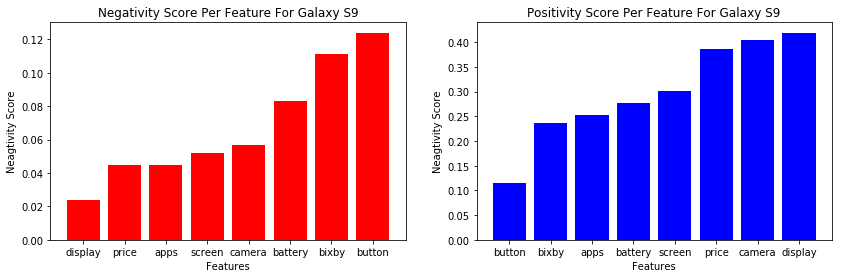

In [36]:
# creating positive and negative bar charts - galaxy
# before creating the plots, we will sort the values
s_sorted_p = s_sentiment.sort_values(by=['positivity'])
s_sorted_n = s_sentiment.sort_values(by=['negativity'])

f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

#negativity
ax.set_title('Negativity Score Per Feature For Galaxy S9')
ax.set_xlabel('Features')
ax.set_ylabel('Neagtivity Score')
ax.bar(s_sorted_n['features'], s_sorted_n['negativity'],width=0.8,color='r',align='center')

#positivity
ax2.set_title("Positivity Score Per Feature For Galaxy S9")
ax2.set_xlabel('Features')
ax2.set_ylabel('Neagtivity Score')
ax2.bar(s_sorted_p['features'], s_sorted_p['positivity'],width=0.8,color='b',align='center')
plt.show()


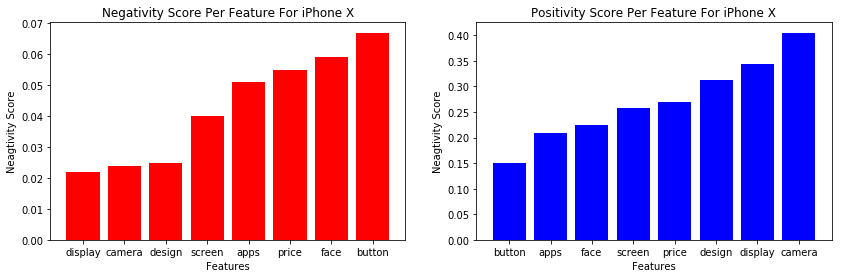

In [37]:
# creating positive and negative bar charts - iphone

a_sorted_p = a_sentiment.sort_values(by=['positivity'])
a_sorted_n = a_sentiment.sort_values(by=['negativity'])

f = plt.figure(figsize=(14,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

#negativity
ax.set_title('Negativity Score Per Feature For iPhone X')
ax.set_xlabel('Features')
ax.set_ylabel('Neagtivity Score')
ax.bar(a_sorted_n['features'], a_sorted_n['negativity'],width=0.8,color='r',align='center') 

#positivity
ax2.set_title("Positivity Score Per Feature For iPhone X")
ax2.set_xlabel('Features')
ax2.set_ylabel('Neagtivity Score')
ax2.bar(a_sorted_p['features'], a_sorted_p['positivity'],width=0.8,color='b',align='center') 

plt.show()

Our 2-gram analysis and 3-gram sentiment quantification strongly agree. Here is what we can tell from the plot above.

#### iPhone X

- It is true that users did not like missing "home button".

- "face" is most-likely stating face recognition problem.

- "price" is a concern in Apple's review. This make senses because iPhone was released at \$999, and Galaxy S9 was released at \$719.99.

- Our team was curious what "screen" meant in the review. After a simple Google search, we found out that there was touch issues and Apple ended up replacing the display module at no cost.

     [iPhone X Screen Problem](https://www.apple.com/support/iphone-x-display-module-replacement-program/)
        



#### Galaxy S9

- missing "button" has been an issue since S8.

- "camera" and "battery" are known problems of Galaxy S series.

- "bixby" is Saumsung version of Apple's Siri. Users doesn't seem to like it. ("bixby" and "button" may be related)

     [Bixby Article](https://www.theverge.com/circuitbreaker/2018/8/15/17683218/samsung-bixby-button-interactive-non-customizable-hardware)

- "price" is still a concern, but not as high as other features.

## Similar Words

- "simple_preprocess" lowercases, tokenizes. – the output are final tokens
<br>
<br>
+ "Word2Vec" is unsupervised natual language processing. Word2vec is a two-layer neural net that turns words into embeding (unique vectors of numbers for each word). Simply put, its input is a text corpus and its output is a set of vectors.
<br>
<br>
+ "most_similar" function takes these vectors and computes vector distance through linear algebra to reveal the most similar words. Fianlly, the distances are normalized and outputs the similarity socre.

**How is this going to help us with our analysis?**

We will input words to find out what certain words mean to consumers.

In [38]:
# split the dataframe by phone
df_a = df[df['phone']=='iphone'].reset_index(drop=True)
df_s = df[df['phone']=='galaxy'].reset_index(drop=True)

#training  iPhone X

documents_a = []

for a in range(len(df_a)):
    doc = gensim.utils.simple_preprocess(df_a['review'][a])
    documents_a.append(doc)


model_a = gensim.models.Word2Vec(documents_a, size=150, window=10, min_count=2, workers=10)
model_a.train(documents_a,total_examples=len(documents_a),epochs=10)

(1216201, 1775050)

In [39]:
#training galaxy S9

documents_s = []

for s in range(len(df_s)):
    doc = gensim.utils.simple_preprocess(df_s['review'][s])
    documents_s.append(doc)


model_s = gensim.models.Word2Vec(documents_s, size=150, window=10, min_count=2, workers=10)
model_s.train(documents_a,total_examples=len(documents_s),epochs=10)

(1160715, 1775050)

<u>NOTE: </u>

The results won't be same when preprocessed tokens go through vectorization since Word2vec uses random assignment on vectorization. I tried setting the seed, but the result still wasn't exactly consistent. This seems to be a common issue in the gensim user community.

<br>
<br>

Now that we trained iPhone X review and Galaxy S9 reviews separately, let's explore the similar words.
<br>

<u>**Interesting Outputs**</u>

The word, "slow" is associated with "authentication", "restart", "earphones", "gps" in iPhone X.

The word, "slow" is associated with "sensor", "scanner", "zoom" "loading", "selfie" in Galaxy S9.

<br>

The word, "terrible" is associated with "accessory", "resistant", "downloading", "cables" in iPhone X.

The word, "terrible" is associated with "filming", "scanner", "loading", "audio" in Galaxy S9.

In [40]:
from IPython.display import display, clear_output
import ipywidgets as widgets

# Create text widget for output
word_output = widgets.Text()

# Create text widget for input
word_input = widgets.Text(
    placeholder="Type a word",
    description='Input: ',
    disabled=False
    )

# Define function to bind value of the input to the output variable 
def bind_input_to_output(sender):
    dd = model_s.wv.most_similar(positive= word_input.value)
    ss = model_a.wv.most_similar(positive= word_input.value)
    print('====================')
    print('input word: ',word_input.value)
    print('======================================================================================================')
    print('--------------------')
    print('iPhone X')
    print('--------------------')
    print(ss)
    print('--------------------')
    print('Galaxy S9')
    print('--------------------')
    print(dd)
    print('======================================================================================================')
# Tell the text input widget to call bind_input_to_output() on submit
word_input.on_submit(bind_input_to_output)

# Display input text box widget for input
display(word_input)



Text(value='', description='Input: ', placeholder='Type a word')

## Model Building

### OLS Regression model using features we created

Let's start out with a simple OLS regression. We picked independent variables, "positivity" and "negativity". We are also replacing "negativity" with "treated_negativity" to see if the accuracy can be improved.


In [41]:
# Passes multicollinearity check. The correlation is mild.

np.corrcoef(df['positivity'], df['treated_negativity'])

array([[ 1.        , -0.39071345],
       [-0.39071345,  1.        ]])

In [42]:
train, test = train_test_split(df, test_size=0.30, random_state=42)

In [43]:

model1 = smf.ols('rating ~ positivity + treated_negativity', data = train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     1659.
Date:                Sun, 21 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:35:18   Log-Likelihood:                -11087.
No. Observations:                9252   AIC:                         2.218e+04
Df Residuals:                    9249   BIC:                         2.220e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.2970      0

In [44]:
#predict
pred1=round(model1.predict(test))

print('=========================================================')
print('treated_negativity model')
print('=========================================================')
print('Accuracy', accuracy_score(y_true = test['rating'], y_pred = pred1))
print('RMSE: ', np.sqrt(mean_squared_error(pred1, test['rating'])))
confusion_matrix(pred1, test['rating'])

treated_negativity model
Accuracy 0.6293494704992436
RMSE:  0.8527491066134608


array([[   0,    1,    1,    0,    0,    0],
       [   5,    0,    6,    2,    2,    0],
       [  26,   18,   31,   34,   44,    0],
       [  82,   66,  168,  323,  676,    0],
       [  10,   11,   29,  286, 2142,    0],
       [   0,    0,    0,    0,    3,    0]], dtype=int64)

In [45]:
model2 = smf.ols('rating ~ positivity + negativity', data = train).fit()

print('=========================================================')
print('negativity model')
print('=========================================================')
pred2=round(model2.predict(test))
print('Accuracy: ', accuracy_score(y_true = test['rating'], y_pred = pred2))
print('RMSE: ', np.sqrt(mean_squared_error(pred2, test['rating'])))
confusion_matrix(pred2, test['rating'])

negativity model
Accuracy:  0.6200201714573877
RMSE:  0.855553481647791


array([[   0,    1,    0,    0,    0,    0],
       [   2,    0,    3,    1,    0,    0],
       [  27,   11,   25,   21,   38,    0],
       [  85,   74,  180,  355,  744,    0],
       [   9,   10,   27,  268, 2079,    0],
       [   0,    0,    0,    0,    6,    0]], dtype=int64)

> The "treated_negativity" model looks performed better as accuracy is higher and RMSE is lower. Coefficients are statistically significant, and this model explains 26% of the variability. It has an accuracy score of 63%. The problem with this model is that predicted values have up to 6-stars because we simply rounded the prediction. We can do better than this.

### Classification Models


To increase our prediction accuracy, iPhone and Galaxy reviews were trained separately.

Lemmatization was performed to increase our accuracy. Lancaster method worked better in our models.

https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

<br>

#### Methodology

- "CountVectorizer" converts a collection of text documents to a matrix of token counts.

- "fit_transform" learns the vocabulary dictionary and it returns a Document-Term matrix. 

- "TfidfTransformer" transforms a count matrix to a normalized tf or tf-idf representation

        TF-IDF means term-frequency times inverse document-frequency.
        This scales down the impact of tokens that occur very frequently in a given corpus and that are less informative.
    
    
<u>Models Used: </u>

- MultinomialNB via GridSearch

- SGDClassifier (Linear SVM) via GridSearch
<br>
<br>

\*GridSearch is a optimization tool that tests a few parameters.

In [46]:
#### training Galaxy S9 #################

# Lemmatizing
porter = PorterStemmer()
lancaster = LancasterStemmer()

X_all_s=[]

for i in range(len(df_s)):
    X_all_s.append(lancaster.stem(df_s['review'][i]))

In [47]:
    
X_train_s, X_test_s, Y_train_s, Y_test_s = train_test_split(X_all_s, df_s['rating'], test_size=0.30, random_state=42)

In [48]:
# MultinomialNB via GirdSearch

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
             'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 0.0005),
}

s_text_clf = text_clf.fit(X_train_s, Y_train_s)

s_gs_clf = GridSearchCV(s_text_clf, parameters, n_jobs=-1)
s_gs_clf = s_gs_clf.fit(X_train_s, Y_train_s)

s_tr_gNB = s_gs_clf.best_score_
s_tr_gNB

C:\Users\tkjan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.7528221668377071

In [49]:
pred_GridNB_s = s_gs_clf.predict(X_test_s)

s_te_gNB = accuracy_score(y_true = Y_test_s, y_pred = pred_GridNB_s)
s_te_gNB

0.7506839945280438

In [50]:
# SVM via GridSearch

text_clf_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),
])

parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf-svm__alpha': (1e-2, 1e-3),
}

s_gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
s_gs_clf_svm = s_gs_clf_svm.fit(X_train_s, Y_train_s)
s_tr_gSVM = s_gs_clf_svm.best_score_
s_tr_gSVM
#gs_clf_svm.best_params_

C:\Users\tkjan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\tkjan\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.72789913502419

In [51]:
pred_GridSVM_s = s_gs_clf_svm.predict(X_test_s)

s_te_gSVM = accuracy_score(y_true = Y_test_s, y_pred = pred_GridSVM_s)
s_te_gSVM

0.7185362517099864

In [52]:
#### training iPhone X #############

porter = PorterStemmer()
lancaster = LancasterStemmer()

X_all=[]

for i in range(len(df_a)):
    X_all.append(lancaster.stem(df_a['review'][i]))
    
    
X_train, X_test, Y_train, Y_test = train_test_split(X_all, df_a['rating'], test_size=0.30, random_state=42)

# MultinomialNB via GirdSearch

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
             'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 0.0005),
}

text_clf = text_clf.fit(X_train, Y_train)

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, Y_train)

a_tr_gNB = gs_clf.best_score_   ###

a_pred_GridNB = gs_clf.predict(X_test)
a_te_gNB = accuracy_score(y_true = Y_test, y_pred = a_pred_GridNB)   ###


# SVM via GridSearch

text_clf_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),
])

parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf-svm__alpha': (1e-2, 1e-3),
}

gs_clf_svm_a = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm_a = gs_clf_svm_a.fit(X_train, Y_train)
a_tr_gSVM = gs_clf_svm_a.best_score_    ###

pred_GridSVM_a = gs_clf_svm_a.predict(X_test)
a_te_gSVM = accuracy_score(y_true = Y_test, y_pred = pred_GridSVM_a)  ###

C:\Users\tkjan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\tkjan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\tkjan\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


### Accuracy

In [53]:
# Model accuracies

pd.DataFrame({'iPhoneX' : [a_tr_gNB, a_te_gNB, a_tr_gSVM, a_te_gSVM], 
              'GalaxyS9' : [s_tr_gNB, s_te_gNB, s_tr_gSVM, s_te_gSVM]},
            index = ['GridNB-Train', 'GridNB-Test', 'GridSVM-Train', 'GridSVM-Test'])

,GalaxyS9,iPhoneX
GridNB-Train,0.752822,0.753599
GridNB-Test,0.750684,0.731286
GridSVM-Train,0.727899,0.749074
GridSVM-Test,0.718536,0.740883


### Prediction

Because we scraped a far more Samsung S9 review, we will create a prediction system using trained NaiveBayes model for Galaxy S9. Simply, type a possible Galaxy S9 review in the below input box.

In [54]:
###### GalaxyS9 #########

word_output1 = widgets.Text()

word_input1 = widgets.Text(
    placeholder="Type a review",
    description='Input: ',
    disabled=False
    )

def bind_input_to_output1(sender):
    print('================================')
    sss=lancaster.stem(word_input1.value)
    ss=s_gs_clf.predict([sss])[0]
    print('Input :', word_input1.value)
    print('Predicted Rating is: ', ss)
    print('================================================================================================================')

word_input1.on_submit(bind_input_to_output1)

display(word_input1)

Text(value='', description='Input: ', placeholder='Type a review')

## Conclusion and Limitation


#### Apple Inc.

- Starting iPhone X generation, Apple got rid of a home button which was considered a bold move in the industry. It is evident that users miss home button. It will be intereting to see if users have gotten used to not having a home button in the later generation (more scraping). 

- Face recognition needs to be more responsive and sensitive. 

- The consensus is that iPhones are priced high.

#### Samsung Electronics

- The battery drainage issue should be fixed.

- The sensors (authentication - fingerprint scanner and face recognition) needs to be more responsive.

- camera needs to be improved.

- come up with better algorithms for Bixby to improve its user interaction.

         
#### More data

As we saw in our prediction model, only 9745 reviews were used to train and test. In order to increase our prediction accuracy, we need far more reviews to train a usuful model. It will be interesting to see how these products evolve from generation to generation in users' reviews.

#### Language is Less Intuitive and messy

Consider following reviews.

In [55]:
print(df['review'][8098])
print(df['review'][9368])

I bought this a month ago and I'm really happy with the product
Great all round phone. Looks great, feels great, and works well. Can't see me wanting to let this one go.


- The first review is a 5-star rating and this sentence is straightforward and easy to understand.

- The second review is also a 5-star review. The last sentence is starting with a negative word "Can't". And you won't know whether this is a positive or negative sentence until you see the word, "go".